# Test & Evaluation Notebook
This notebook contains the evaluation pipeline for the YedroudjNet512 steganalysis model.
I removed duplicated cells and added short explanations before each code block to clarify purpose and usage.

## 1) Imports and utilities
This cell imports core libraries required for dataset handling, model code, metrics and plotting.

In [1]:
import os
import random
import numpy as np
from PIL import Image
import torch
from torch import amp
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import argparse
import math
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, f1_score,
    precision_score, recall_score, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


## 2) Configuration
Set dataset paths, training/evaluation hyperparameters, random seeds and device selection.

In [2]:
# Configuration
COVER_DIR = "c"                    # 512x512 covers
STEGO_DIR = "stego_suniward"       # 512x512 stegos
IMG_SIZE = 512
BATCH_SIZE = 8        
NUM_EPOCHS = 60
LR = 1e-3
WEIGHT_DECAY = 1e-5
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
SEED = 42
PRINT_EVERY = 20      # tqdm updates
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Setting same seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.startswith("cuda"):
    torch.cuda.manual_seed_all(SEED)

print("Using device:", DEVICE)
print("Covers dir:", COVER_DIR)
print("Stego dir:", STEGO_DIR)
print("Image size:", IMG_SIZE, "Batch size:", BATCH_SIZE)

Using device: cuda
Covers dir: c
Stego dir: stego_suniward
Image size: 512 Batch size: 8


## 3) Model definitions (SRM + Yedroudj-Net)
Defines the SRM high-pass filters and the YedroudjNet512 architecture used for steganalysis.

In [3]:
# SRM Filter (3 kernels)
class SRMFilter(nn.Module):
    def __init__(self):
        super().__init__()
        HPF = np.zeros((3, 1, 5, 5), dtype=np.float32)

        HPF[0, 0] = np.array([
            [0, 0, 0, 0, 0],
            [0, -1, 2, -1, 0],
            [0,  2, -4,  2, 0],
            [0, -1, 2, -1, 0],
            [0, 0, 0, 0, 0],
        ], dtype=np.float32) / 4.0

        HPF[1, 0] = np.array([
            [-1, 2, -2, 2, -1],
            [2, -6, 8, -6, 2],
            [-2, 8, -12, 8, -2],
            [2, -6, 8, -6, 2],
            [-1, 2, -2, 2, -1],
        ], dtype=np.float32) / 12.0

        HPF[2, 0] = np.array([
            [0, 0, 0, 0, 0],
            [0, 1, -2, 1, 0],
            [0, -2, 4, -2, 0],
            [0, 1, -2, 1, 0],
            [0, 0, 0, 0, 0],
        ], dtype=np.float32) / 4.0

        self.register_buffer("weight", torch.from_numpy(HPF))

    def forward(self, x):
        # x: (N,1,H,W) in [0,255]
        return F.conv2d(x, self.weight, padding=2)


# Yedroudj-Net (practical variant)
def conv_block(in_c, out_c, pool='avg', drop=0.0):
    layers = []
    layers.append(nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False))
    layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False))
    layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.ReLU(inplace=True))
    if pool == 'avg':
        layers.append(nn.AvgPool2d(2))
    elif pool == 'max':
        layers.append(nn.MaxPool2d(2))
    if drop > 0:
        layers.append(nn.Dropout(drop))
    return nn.Sequential(*layers)

class YedroudjNet512(nn.Module):
    def __init__(self, tlu=3.0):
        super().__init__()
        self.srm = SRMFilter()
        self.tlu = float(tlu)

        # Blocks tuned for 512 input
        self.block1 = conv_block(3, 32, pool='avg', drop=0.2)   # 512 -> 256
        self.block2 = conv_block(32, 64, pool='max', drop=0.25) # 256 -> 128
        self.block3 = conv_block(64, 128, pool='max', drop=0.35)# 128 -> 64
        self.block4 = conv_block(128, 256, pool='max', drop=0.45)# 64 -> 32
        self.block5 = conv_block(256, 512, pool='avg', drop=0.5) # 32 -> 16

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        # x in [0,255], shape (N,1,512,512)
        x = self.srm(x)                    # -> (N,3,512,512)
        x = torch.clamp(x, -self.tlu, self.tlu)
        x = torch.abs(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.pool(x)
        return self.head(x)

## 4) Dataset class & transforms
Defines a paired dataset loader (matched cover/stego filenames) and the transforms used.

In [4]:
# Dataset loader (paired)
class PairedStegoDataset(Dataset):
    def __init__(self, cover_dir, stego_dir, transform=None):
        self.cover_dir = cover_dir
        self.stego_dir = stego_dir
        self.transform = transform

        cover_files = sorted(os.listdir(cover_dir))
        stego_files = sorted(os.listdir(stego_dir))
        matched = sorted(list(set(cover_files) & set(stego_files)))
        if len(matched) == 0:
            raise RuntimeError("No matched filenames found between cover and stego directories")

        self.samples = []
        for fname in matched:
            self.samples.append((os.path.join(cover_dir, fname), 0.0))
            self.samples.append((os.path.join(stego_dir, fname), 1.0))

        print(f"Found {len(matched)} matched pairs")
        print(f"Total samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, label = self.samples[idx]
        img = Image.open(p).convert("L")
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
            img = img * 255.0
        return img, torch.tensor(label, dtype=torch.float32)



# Transforms: no normalization! only ToTensor * 255
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t * 255.0)
])
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t * 255.0)
])


## 5) Quick embedding diagnostics
Utility to inspect matched cover/stego pairs and SRM differences before running evaluation.

In [5]:
# Utility: quick embedding check (runs once)
def quick_embedding_check(cover_dir, stego_dir, n=5):
    # pick up to n matched filenames and compute pixel diffs and SRM diffs
    files = sorted(list(set(os.listdir(cover_dir)) & set(os.listdir(stego_dir))))
    files = files[:n]
    if len(files) == 0:
        print("No pairs to check")
        return
    srm = SRMFilter().to(DEVICE)
    srm.eval()
    print("Quick embedding diagnostics on up to", n, "pairs:")
    for fname in files:
        cpath = os.path.join(cover_dir, fname)
        spath = os.path.join(stego_dir, fname)
        c = Image.open(cpath).convert("L")
        s = Image.open(spath).convert("L")
        ca = np.array(c, dtype=np.int16)
        sa = np.array(s, dtype=np.int16)
        diff = sa - ca
        nonzero = int((diff != 0).sum())
        maxabs = int(np.max(np.abs(diff)))
        print(f" {fname}: pixel nonzero count={nonzero}, maxabs={maxabs}")
        # SRM diff
        ct = transforms.ToTensor()(c).unsqueeze(0).to(DEVICE) * 255.0
        st = transforms.ToTensor()(s).unsqueeze(0).to(DEVICE) * 255.0
        with torch.no_grad():
            rc = srm(ct)
            rs = srm(st)
            rdiff = (rs - rc)
            print(f"   SRM std cover={rc.std().item():.3f}, stego={rs.std().item():.3f}, diff_std={rdiff.std().item():.5f}")

## 6) Training helpers (metrics, training/eval loops)
Contains helper functions used by training and evaluation: accuracy computation, training epoch loop and evaluation loop.

In [6]:
# Metrics & train/eval loops (AMP + tqdm)
def accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()
    return (preds == labels).float().mean().item()

def train_one_epoch(model, loader, optimizer, scaler, criterion, epoch):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total = 0

    pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch}", ncols=120)
    for batch_idx, (imgs, labels) in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()
        with amp.autocast(device_type="cuda", enabled=DEVICE.startswith("cuda")):
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = imgs.size(0)
        running_loss += loss.item() * bs
        batch_acc = accuracy_from_logits(logits, labels)
        running_acc += batch_acc * bs
        total += bs

        if (batch_idx + 1) % PRINT_EVERY == 0 or (batch_idx + 1) == len(loader):
            pbar.set_postfix({
                "loss": f"{running_loss/total:.4f}",
                "acc": f"{running_acc/total:.4f}",
                "lr": f"{optimizer.param_groups[0]['lr']:.6f}"
            })

    return running_loss / total, running_acc / total

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    total = 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", ncols=120):
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE).unsqueeze(1)
            logits = model(imgs)
            loss = criterion(logits, labels)
            bs = imgs.size(0)
            running_loss += loss.item() * bs
            running_acc += accuracy_from_logits(logits, labels) * bs
            total += bs
    return running_loss / total, running_acc / total


## 7) Main training script
The main training entrypoint used to train the model and save the best checkpoint.

In [7]:


# Main training script
def main():
    # quick diagnostics
    quick_embedding_check(COVER_DIR, STEGO_DIR, n=5)

    # dataset and splits
    dataset = PairedStegoDataset(COVER_DIR, STEGO_DIR, train_transform)
    N = len(dataset)
    n_test = int(TEST_SPLIT * N)
    n_val = int(VAL_SPLIT * N)
    n_train = N - n_val - n_test
    print("Dataset size:", N, "train/val/test:", n_train, n_val, n_test)

    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test],
                                             generator=torch.Generator().manual_seed(SEED))
    # ensure transforms
    train_ds.dataset.transform = train_transform
    val_ds.dataset.transform = eval_transform
    test_ds.dataset.transform = eval_transform

    use_cuda = DEVICE.startswith("cuda")
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=use_cuda)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=use_cuda)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=use_cuda)

    # model, optimizer, scheduler
    model = YedroudjNet512(tlu=3.0).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, min_lr=1e-6)
    criterion = nn.BCEWithLogitsLoss()
    scaler = amp.GradScaler(device="cuda", enabled=use_cuda)

    # remove existing checkpoint
    if os.path.exists("best_yedroudj_512_test.pt"):
        os.remove("best_yedroudj_512_test.pt")

    best_val = 0.0
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, criterion, epoch)
        val_loss, val_acc = eval_model(model, val_loader, criterion)

        print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | Train: {train_loss:.4f}, acc {train_acc:.4f} | Val: {val_loss:.4f}, acc {val_acc:.4f}")

        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), "best_yedroudj_512_test.pt")
            print(" → Saved best model")

        scheduler.step(val_acc)

if __name__ == "__main__":
    main()


Quick embedding diagnostics on up to 5 pairs:
 1.pgm: pixel nonzero count=21344, maxabs=1
   SRM std cover=5.357, stego=5.387, diff_std=0.48355
 10.pgm: pixel nonzero count=19698, maxabs=1
   SRM std cover=6.932, stego=6.948, diff_std=0.46754
 100.pgm: pixel nonzero count=19769, maxabs=1
   SRM std cover=5.161, stego=5.183, diff_std=0.46882
 1000.pgm: pixel nonzero count=21967, maxabs=1
   SRM std cover=7.444, stego=7.462, diff_std=0.49247
 10000.pgm: pixel nonzero count=20458, maxabs=1
   SRM std cover=4.406, stego=4.431, diff_std=0.47340
Found 10000 matched pairs
Total samples: 20000
Dataset size: 20000 train/val/test: 14000 3000 3000


Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:20<00:00, 18.05it/s]

Epoch 01/60 | Train: 0.6908, acc 0.5335 | Val: 0.6820, acc 0.5720
 → Saved best model



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:19<00:00, 19.40it/s]

Epoch 02/60 | Train: 0.6816, acc 0.5514 | Val: 0.6777, acc 0.5443



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:20<00:00, 18.31it/s]

Epoch 03/60 | Train: 0.6894, acc 0.5132 | Val: 0.7038, acc 0.5117



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 04/60 | Train: 0.6921, acc 0.4999 | Val: 0.6932, acc 0.5000



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 05/60 | Train: 0.6917, acc 0.5128 | Val: 1.1835, acc 0.5053



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 06/60 | Train: 0.6765, acc 0.5577 | Val: 0.6400, acc 0.5830
 → Saved best model



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 07/60 | Train: 0.6533, acc 0.5799 | Val: 0.6445, acc 0.5687



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.22it/s]


Epoch 08/60 | Train: 0.6502, acc 0.5826 | Val: 0.6066, acc 0.6163
 → Saved best model


Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 09/60 | Train: 0.6399, acc 0.5855 | Val: 0.6401, acc 0.6100



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.19it/s]

Epoch 10/60 | Train: 0.6305, acc 0.5960 | Val: 0.5939, acc 0.6197
 → Saved best model



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 11/60 | Train: 0.6278, acc 0.6107 | Val: 0.6360, acc 0.5707



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:18<00:00, 19.76it/s]

Epoch 12/60 | Train: 0.6179, acc 0.6109 | Val: 0.5878, acc 0.6167



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:19<00:00, 19.66it/s]

Epoch 13/60 | Train: 0.6100, acc 0.6216 | Val: 0.5818, acc 0.6407
 → Saved best model



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:18<00:00, 19.83it/s]

Epoch 14/60 | Train: 0.6048, acc 0.6288 | Val: 0.5585, acc 0.6690
 → Saved best model



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:19<00:00, 19.73it/s]

Epoch 15/60 | Train: 0.6017, acc 0.6295 | Val: 0.5993, acc 0.6410



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:18<00:00, 19.79it/s]

Epoch 16/60 | Train: 0.6036, acc 0.6335 | Val: 0.5760, acc 0.6200



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:19<00:00, 19.68it/s]

Epoch 17/60 | Train: 0.6012, acc 0.6378 | Val: 0.8657, acc 0.5357



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:18<00:00, 19.94it/s]

Epoch 18/60 | Train: 0.5938, acc 0.6408 | Val: 0.5796, acc 0.6293



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:19<00:00, 19.73it/s]

Epoch 19/60 | Train: 0.5921, acc 0.6461 | Val: 0.6199, acc 0.5877



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:18<00:00, 19.81it/s]

Epoch 20/60 | Train: 0.5765, acc 0.6482 | Val: 0.5389, acc 0.6700
 → Saved best model



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:19<00:00, 19.67it/s]

Epoch 21/60 | Train: 0.5700, acc 0.6612 | Val: 0.5330, acc 0.6973
 → Saved best model



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:18<00:00, 19.78it/s]

Epoch 22/60 | Train: 0.5681, acc 0.6645 | Val: 0.5824, acc 0.6313



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:18<00:00, 19.82it/s]

Epoch 23/60 | Train: 0.5702, acc 0.6619 | Val: 0.6759, acc 0.5733



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:18<00:00, 19.74it/s]

Epoch 24/60 | Train: 0.5712, acc 0.6647 | Val: 0.5479, acc 0.6713



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.22it/s]

Epoch 25/60 | Train: 0.5667, acc 0.6706 | Val: 0.5300, acc 0.6807



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 26/60 | Train: 0.5642, acc 0.6675 | Val: 0.5576, acc 0.6613



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.22it/s]

Epoch 27/60 | Train: 0.5528, acc 0.6749 | Val: 0.5303, acc 0.6843



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 28/60 | Train: 0.5521, acc 0.6744 | Val: 0.5410, acc 0.6790



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.22it/s]

Epoch 29/60 | Train: 0.5456, acc 0.6809 | Val: 0.5274, acc 0.6920



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 30/60 | Train: 0.5463, acc 0.6809 | Val: 0.5219, acc 0.7057
 → Saved best model



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]


Epoch 31/60 | Train: 0.5428, acc 0.6835 | Val: 0.5544, acc 0.6690


Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 32/60 | Train: 0.5412, acc 0.6872 | Val: 0.5335, acc 0.6837



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]


Epoch 33/60 | Train: 0.5409, acc 0.6879 | Val: 0.5115, acc 0.7133
 → Saved best model


Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 34/60 | Train: 0.5387, acc 0.6887 | Val: 0.5133, acc 0.7103



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.19it/s]

Epoch 35/60 | Train: 0.5373, acc 0.6856 | Val: 0.5296, acc 0.6940



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 36/60 | Train: 0.5367, acc 0.6916 | Val: 0.5961, acc 0.6470



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]


Epoch 37/60 | Train: 0.5390, acc 0.6852 | Val: 0.5126, acc 0.7177
 → Saved best model


Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]


Epoch 38/60 | Train: 0.5344, acc 0.6882 | Val: 0.5229, acc 0.7060


Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 39/60 | Train: 0.5377, acc 0.6902 | Val: 0.5267, acc 0.6857



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 40/60 | Train: 0.5322, acc 0.6907 | Val: 0.5167, acc 0.6967



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 41/60 | Train: 0.5305, acc 0.6956 | Val: 0.5096, acc 0.7123



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 42/60 | Train: 0.5304, acc 0.6969 | Val: 0.5160, acc 0.7120



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 43/60 | Train: 0.5250, acc 0.6949 | Val: 0.5208, acc 0.6953



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 44/60 | Train: 0.5239, acc 0.6968 | Val: 0.5392, acc 0.6887



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 45/60 | Train: 0.5227, acc 0.7016 | Val: 0.6099, acc 0.6600



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 46/60 | Train: 0.5231, acc 0.6988 | Val: 0.5988, acc 0.6777



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 47/60 | Train: 0.5223, acc 0.7026 | Val: 0.4988, acc 0.7263
 → Saved best model



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 48/60 | Train: 0.5195, acc 0.7030 | Val: 0.6048, acc 0.6637



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 49/60 | Train: 0.5213, acc 0.7046 | Val: 0.5106, acc 0.7113



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 50/60 | Train: 0.5182, acc 0.7028 | Val: 0.4939, acc 0.7207



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.22it/s]


Epoch 51/60 | Train: 0.5185, acc 0.7024 | Val: 0.4955, acc 0.7270
 → Saved best model


Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 52/60 | Train: 0.5182, acc 0.7011 | Val: 0.5042, acc 0.7250



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 53/60 | Train: 0.5176, acc 0.7034 | Val: 0.4977, acc 0.7250



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 54/60 | Train: 0.5161, acc 0.7003 | Val: 0.5100, acc 0.7153



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.19it/s]

Epoch 55/60 | Train: 0.5122, acc 0.7088 | Val: 0.4995, acc 0.7203



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 56/60 | Train: 0.5144, acc 0.7000 | Val: 0.5662, acc 0.6750



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 57/60 | Train: 0.5093, acc 0.7104 | Val: 0.5191, acc 0.7007



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]


Epoch 58/60 | Train: 0.5119, acc 0.7066 | Val: 0.4945, acc 0.7227


Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.20it/s]

Epoch 59/60 | Train: 0.5133, acc 0.7024 | Val: 0.4825, acc 0.7367
 → Saved best model



Val: 100%|████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.21it/s]

Epoch 60/60 | Train: 0.5125, acc 0.7112 | Val: 0.5022, acc 0.7133


## 8) Prepare test loader for evaluation
When running evaluation (below) we need a `test_loader`. This small cell rebuilds the paired dataset and creates a test loader using the already-defined `PairedStegoDataset` to avoid duplicating dataset classes.

In [8]:
# Build dataset and test loader for evaluation (non-duplicate, concise)
dataset = PairedStegoDataset(COVER_DIR, STEGO_DIR, eval_transform)
N = len(dataset)
n_test = int(TEST_SPLIT * N)
n_val = int(VAL_SPLIT * N)
n_train = N - n_val - n_test
from torch.utils.data import random_split
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
print("Test loader ready.")

Found 10000 matched pairs
Total samples: 20000
Test loader ready.


## 9) Load model checkpoint
Load the best checkpoint saved during training and prepare the model for evaluation.

In [9]:
model = YedroudjNet512().to(DEVICE)

state = torch.load(
    "best_yedroudj_512.pt",
    map_location=DEVICE,
    weights_only=True
)

model.load_state_dict(state)
model.eval()

print("Model loaded successfully.")

Model loaded successfully.


## 10) Evaluation & Metrics
Run the model on the `test_loader`, collect predictions and compute common evaluation metrics and plots.

FINAL EVALUATION METRICS
Accuracy  : 0.7287
Precision : 0.7181
Recall    : 0.7571
F1 Score  : 0.7371


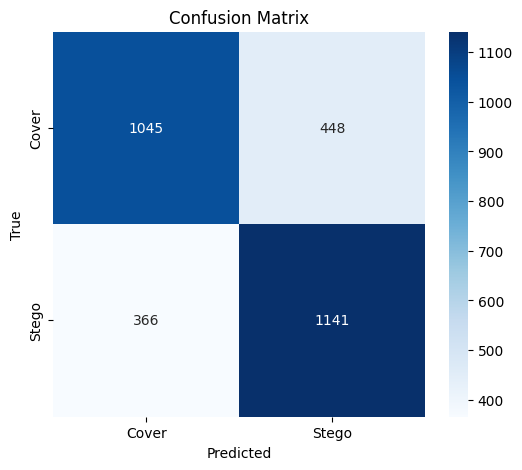

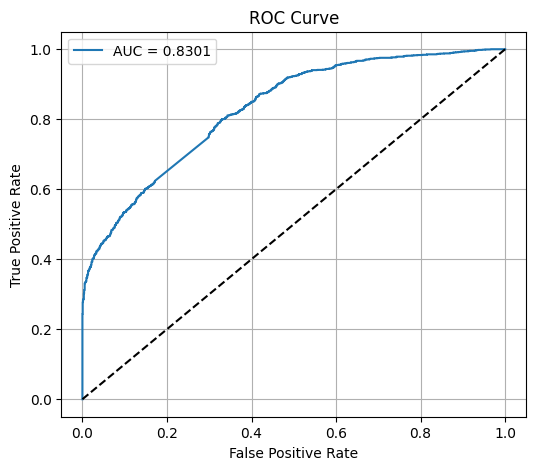

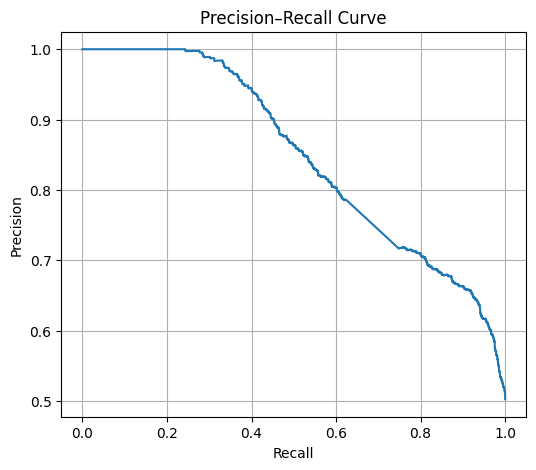

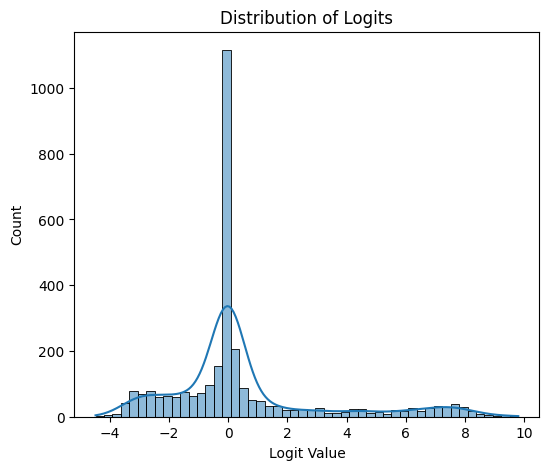

In [10]:
# 1. Collect predictions on test set
model.eval()
all_labels = []
all_probs = []
all_logits = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(imgs).squeeze(1)
        probs = torch.sigmoid(logits)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_logits.extend(logits.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_logits = np.array(all_logits)

preds = (all_probs >= 0.5).astype(int)


# 2. Compute core metrics
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)

print("=====================================")
print("FINAL EVALUATION METRICS")
print("=====================================")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

# 3. Confusion Matrix
cm = confusion_matrix(all_labels, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Cover","Stego"],
            yticklabels=["Cover","Stego"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 4. ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# 5. Precision–Recall Curve
prec_curve, rec_curve, _ = precision_recall_curve(all_labels, all_probs)

plt.figure(figsize=(6,5))
plt.plot(rec_curve, prec_curve)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# 6. Distribution of logits
plt.figure(figsize=(6,5))
sns.histplot(all_logits, bins=50, kde=True)
plt.title("Distribution of Logits")
plt.xlabel("Logit Value")
plt.show()
